<center><img src='' width=100%></center>  

<center>
    <h1>Predicting Communicative Intention in Code Review Questions</h1>
    <h3>Lab 2 || Data-driven Software Engineering || Offered by Dr. Shaowei Wang</h3>
    <h3>University of Manitoba - Fall 2020</h3>
    <h3>Pooya Nikbakht (#7864707)</h3>
</center>

<br />
<br />
<br />
<br />
<br />


# Setting Initial Parameters of The Program
<a name="imp_lib"></a>

set the source file of DB:

In [1]:
#Dataset sources (on Github):
csv_db_address = 'https://github.com/Pooya-Nikbakht/SE-Lab2/raw/main/lab2_db_mainQuestion.csv'

set what percentage of the whole dataset should be considered as the test dataset:

In [146]:
#test dataset size
test_split_portion = 0.25  #0.25 for considering the last 25% of the whole dataset as the test dataset

set which pre-processing jobs should be done for question 1 and 2 in addition to word tokenizing?

In [3]:
#Stemming the questions before tokenizing?
do_stemming = False

#Removing the stop words from the questions before tokenizing?
remove_stop_words = False

#Using keyQuestions instead of rawQuestions to train the models
use_keyQuestions_to_train = True  #if False, it will use rawQuestions to train the models

set which new attributes should be considered for Questions 2 and Question 3:

In [4]:
#sentiment attribute
add_sentiment = True

#question-length attribute
add_question_lengths = True

set which classification methods should be used to build the classifiers:

In [5]:
#The first method with value "True" is applied

#- Random Forest?
use_random_forest = True

#- XGBoost?
use_xgboost = False

#- k-Nearest neighbors?
use_knn = False

# Imorting Libraries
<a name="imp_lib"></a>

In [6]:
#Arrays and Matrices Libraries
import numpy as np 

#Plotting Libraries
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import six

#Data Analysis Libraries
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
import sys
!{sys.executable} -m pip install xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.porter import PorterStemmer

import nltk
from nltk.corpus import stopwords 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Libraries for time
import time
import datetime

#Other Libraries
import random
import math
import operator 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gadalab\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Definition of functions
<a name="init_param"></a>

In [7]:
#a fucntion to transform a raw label to its corresponding final label
def label(str):
    switch={
        'suggestion':'suggestion',
        'request for action':'request',
        'request for confirmation':'request',
        'request for clarification':'request',
        'request for information':'request',
        'request for opinion':'request',
        'request for rationale':'request',
        'anger':'attitude and emotion',
        'criticism':'attitude and emotion',
        'surprise':'attitude and emotion',
        'rhetorical question':'rhetorical question',
        'hypothetical scenario':'hypothetical scenario',
     }
    return switch.get(str,"others")


#a function to transform all labels of input array to the corresponding final labels
def modifyLabels(inputArray, labelColumnIndex):
    tmpArray = inputArray.copy()
    for i in range(len(tmpArray)):
        tmpArray[i][labelColumnIndex] = label(tmpArray[i][labelColumnIndex])
    
    return tmpArray


#a fuction that applies stemming to the input array and return the stemmed array
def get_stemmed_text(texts):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in texts]


#a fuction to calculate the lenght of each element of an input string array
def getLenghts(inputArr):
    rowLenghts = inputArr.copy()
    for i in range(len(rowLenghts)):
        rowLenghts[i] = len(rowLenghts[i])
            
    return rowLenghts


#a function to calculate the sentiment of each array's element. Return value is a list of dictionaries
#-- {'neg': a, 'neu': b, 'pos': c, 'compound': d} where a, b, c, and d are fload values.
def getSentiment(inputArr, justCompound = False):
    analyzer = SentimentIntensityAnalyzer()
    
    rowSentiments = []
    for i in range(len(inputArr)):
        if(justCompound):
            tmpDic = analyzer.polarity_scores(inputArr[i])
            tmpDic.pop("neg")
            tmpDic.pop("neu")
            tmpDic.pop("pos")
            rowSentiments.append(tmpDic)
        else:
            rowSentiments.append(analyzer.polarity_scores(inputArr[i]))
            
    return rowSentiments


#a function to convert categorical labels into a binary numerical form
def encodeLabels(inputLabels):
    encodeList = []
    for i in range(len(inputLabels)):
        if(inputLabels[i] == "request"):
            encodeList.append([1,0,0,0,0])
        if(inputLabels[i] == "suggestion"):
            encodeList.append([0,1,0,0,0])
        if(inputLabels[i] == "attitude and emotion"):
            encodeList.append([0,0,1,0,0])
        if(inputLabels[i] == "rhetorical question"):
            encodeList.append([0,0,0,1,0])
        if(inputLabels[i] == "hypothetical scenario"):
            encodeList.append([0,0,0,0,1])
    
    return encodeList


# Preparing initial raw train and test datasetes

### Importing the original dataset
<a name="imp_data"></a>

In [8]:
#reading the raw dataset as a data frame
raw_db_df = pd.read_csv(csv_db_address)

#converting the target db to array
raw_db = raw_db_df.to_numpy()

#printing
raw_db_df.sample(5)

,inline-comment-id,# Comment,Question,Main Question,Final Label
36,7c21d2e1_037dfdb6,37,"I'm not sure how you compete for a dependency,...",Is executing 2 recipes in the same shell simul...,request for clarification
196,1630777d_19334f2d,197,Not sure I understand this comment. Could you ...,Could you expand?,request for action
382,011d984d_72cb465c,383,Can these components be changed to a custom pa...,Can these components be changed to a custom pa...,suggestion
163,f48a499e_dd798be3,164,Why are the arguments passed by value instead ...,Why are the arguments passed by value instead ...,request for rationale
381,21e9bccf_02eeae8f,382,Can you add a short comment on the intent? I a...,I assume this would cause GC-for-alloc to trig...,request for confirmation


### Modifying labels

Printing all distinct labels of the raw database:

In [9]:
#printing all distinct labels
np.unique(raw_db[:,-1])

array(['action', 'anger', 'criticism', 'discarded',
       'hypothetical scenario', 'request for action',
       'request for clarification', 'request for confirmation',
       'request for information', 'request for opinion',
       'request for rationale', 'rhetorical question', 'suggestion',
       'surprise'], dtype=object)

Changing the raw labels to target labels:

In [147]:
#modifying labels to the target labels and update the array db
raw_db = modifyLabels(raw_db, -1)

#update dataFrame db
raw_db_df = pd.DataFrame(raw_db)
raw_db_df = raw_db_df.rename(columns={0: "commentID", 1: "comment#", 2: "rawQuestion", 3: "keyQuestion", 4: "Label"})
raw_db_df.sample(5)

,commentID,comment#,rawQuestion,keyQuestion,Label
302,30b3c3fb_9d4063be,310,variable_info? That's quite misleading for a p...,How about __reserved?,suggestion
373,21e9bccf_02eeae8f,381,Can you add a short comment on the intent? I a...,Can you add a short comment on the intent?,others
206,79c9c09b_364e36ba,211,Remove this as well?\n,Remove this as well?,suggestion
438,d965302b_14e53469,446,"""Number of steps reported (%d) is greater than...","""Number of steps reported (%d) is greater than...",others
25,7689e6a7_df9a5b93,26,this local is only used once? inline?\n,inline?,suggestion


Printing all updated distinct labels:

In [12]:
np.unique(raw_db[:,-1])

array(['attitude and emotion', 'hypothetical scenario', 'others',
       'request', 'rhetorical question', 'suggestion'], dtype=object)

Removing records with labels of no interest (label "others"):

In [149]:
#removing the records with the labels other than our target labels
raw_db_df = raw_db_df[raw_db_df.Label != "others"]

#reset the indexes
raw_db_df = raw_db_df.reset_index(drop=True)

#update processed_train_db
raw_db = np.array(raw_db_df)


Printing all distinct final labels:

In [14]:
np.unique(raw_db[:,-1])

array(['attitude and emotion', 'hypothetical scenario', 'request',
       'rhetorical question', 'suggestion'], dtype=object)

## Forming initial train and test datasets
<a name="imp_data"></a>

Spliting the raw input db into training and test datasets:

In [15]:
#Spliting the input db into training and test datasets:
raw_train_db, raw_test_db, raw_train_labels, raw_test_labels = train_test_split(raw_db[:],
                                                                    raw_db_df.iloc[:, -1:].to_numpy()[:],
                                                                    test_size=test_split_portion, shuffle=False) 

#converting train db into data frame
raw_train_db_df = pd.DataFrame(raw_train_db)
raw_train_db_df = raw_train_db_df.rename(columns={0: "commentID", 1: "comment#", 2: "rawQuestion",
                                                  3: "keyQuestion", 4: "Label"})

#converting test db into data frame
raw_test_db_df = pd.DataFrame(raw_test_db)
raw_test_db_df = raw_test_db_df.rename(columns={0: "commentID", 1: "comment#", 2: "rawQuestion",
                                                3: "keyQuestion", 4: "Label"})


Printing the size of raw test and train datasets:

In [16]:
#Printing the size of train dataset
print("size of raw train dataset: " + str(len(raw_train_db)) + " records out of " + str(len(raw_db)))

#Printing the size of test dataset
print("size of raw test dataset: " + str(len(raw_test_db)) + " records out of " + str(len(raw_db)))

size of raw train dataset: 344 records out of 492
size of raw test dataset: 148 records out of 492


# Basic β-Preprocessing (tokenizing the rawQuestions)

### Forming target train dataset

In [17]:
#creating a new data frame
basicProcessed_train_db_df = pd.DataFrame()

#adding the raw questions from train db
basicProcessed_train_db_df['rawQuestion'] = raw_train_db_df["rawQuestion"]

#adding corresponding labels
basicProcessed_train_db_df['Label'] = raw_train_db_df["Label"]

#converting the target db to array
basicProcessed_train_db = basicProcessed_train_db_df.to_numpy()

basicProcessed_train_db_df

,rawQuestion,Label
0,is this what they intended? don't they really ...,request
1,is this what they intended? don't they really ...,attitude and emotion
2,Don't we need to increment 'i' in the else cas...,suggestion
3,i can't see anywhere where this is set to fals...,suggestion
4,are you sure you want to include this source f...,attitude and emotion
...,...,...
339,Would you like this string to have xliff forma...,request
340,Would it not be better to just check emulator-...,suggestion
341,"Can you make these different? For example, can...",request
342,"Can you make these different? For example, can...",suggestion


### Tokenizing rawQuestions

Tokenize while removing stop words:

In [18]:
#building the basic_vectorizer
basic_vectorizer = CountVectorizer(analyzer='word')

#tokenize while removing stop words and create the word vectors
basic_word_vectors = basic_vectorizer.fit_transform(basicProcessed_train_db[:,0])

#print all tokens
print(basic_vectorizer.get_feature_names())

#basic_vectorizer2 = Countbasic_vectorizer(analyzer='word', ngram_range=(2, 2))
#X2 = basic_vectorizer2.fit_transform(corpus)
#print(basic_vectorizer2.get_feature_names())
#print(X2.toarray())


['0x0', '0x0101', '0x0104', '10', '100', '1175', '1202', '13', '157', '168', '17', '19', '1ghz', '20', '2001', '270', '278137', '32', '52', '5mhz', '64', '64bits', '65535', '936', '937', '950â', '951', '9ms', '__android_api__', '__bionic_fortify', '__reserved', '_hoping_', '_really_', '_should_', 'aaargh', 'abc', 'abi', 'able', 'about', 'above', 'abstraction', 'acceptable', 'accepted', 'access', 'accesses', 'accessible', 'accident', 'account', 'across', 'act', 'acting', 'actions', 'actively', 'acts', 'actual', 'actually', 'adaptor', 'adaptor_bus_', 'adb_basename', 'adb_trace_init', 'adb_unlink', 'add', 'addattachedwindowtolistlocked', 'added', 'adding', 'additional', 'address', 'address_sanitizer_runtime_library', 'addstoragelocked', 'adjacent', 'adjust', 'af_inet', 'af_inet6', 'affect', 'afraid', 'after', 'again', 'against', 'ages', 'agree', 'align', 'alignment', 'alive', 'all', 'allow', 'along', 'already', 'also', 'alternative', 'although', 'always', 'amended', 'an', 'and', 'android'

Creating a new db including word vectors:

In [150]:
#creating a new df containing the word vectors
basicProcessed_vector_train_db_df = pd.DataFrame(np.array(basic_word_vectors.toarray()))

#adding the label to the end
basicProcessed_vector_train_db_df['Label'] = basicProcessed_train_db_df["Label"]

#converting the new df to array
basicProcessed_vector_train_db = np.array(basicProcessed_vector_train_db_df)

#printing some random records
basicProcessed_vector_train_db_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,1536,1537,1538,1539,1540,1541,1542,1543,1544,Label
272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suggestion
261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,request
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,request


### Forming the final train and test datasets based on basic pre-processing


In [20]:
#train attributes
basicProcessed_train_data = np.array(basicProcessed_vector_train_db_df.iloc[:, :-1])

#train labels
basicProcessed_train_labels = np.array(basicProcessed_vector_train_db_df.iloc[:, -1:])

#vectorizing raw questions in the test dataset into word vectors
basicProcessed_test_data = basic_vectorizer.transform(raw_test_db_df["rawQuestion"])
#test attributes: converting the vectors into array
basicProcessed_test_data = basicProcessed_test_data.toarray()

#test labels
basicProcessed_test_labels = np.array(raw_test_db_df.iloc[:, -1:])


In [152]:
print("final train data based on basic pre-processing:")
pd.DataFrame(basicProcessed_train_data)

final train data based on basic pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
341,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
342,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
print("final test data based on basic pre-processing:")
pd.DataFrame(basicProcessed_test_data)

final test data based on basic pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Advanced α-Preprocessor (stemming, stopWords, and tokenizing)

### Forming target train dataset

In [23]:
#creating a new data frame
processed_train_db_df = pd.DataFrame()

#adding questions from train db
if(use_keyQuestions_to_train):
    processed_train_db_df['Question'] = raw_train_db_df["keyQuestion"]
else:
    processed_train_db_df['Question'] = raw_train_db_df["rawQuestion"]


#adding corresponding labels
processed_train_db_df['Label'] = raw_train_db_df["Label"]

#converting the target db to array
processed_train_db = processed_train_db_df.to_numpy()
processed_train_db.shape

processed_train_db_df

,Question,Label
0,is this what they intended?,request
1,don't they really want $(TARGET_OUT_DATA_NATIV...,attitude and emotion
2,Don't we need to increment 'i' in the else cas...,suggestion
3,should we just adjust the single reference in ...,suggestion
4,are you sure you want to include this source f...,attitude and emotion
...,...,...
339,Would you like this string to have xliff forma...,request
340,Would it not be better to just check emulator-...,suggestion
341,Can you make these different?,request
342,"For example, can this one be 2001:db8:1::13?",suggestion


### Check if there is any empy cell to deal with?

In [24]:
raw_db_df.isnull().sum().sum()

0

### Stemming

In [25]:
#stemming the original questions
if(do_stemming):
    input_questions = get_stemmed_text(processed_train_db[:,0])
else:
    input_questions = processed_train_db[:,0]

### Tokenizing and removing stop words

Tokenize while removing stop words:

In [26]:
#set the stop_words 
#stop_words = set(stopwords.words('english')) 
stop_words = ENGLISH_STOP_WORDS


#building the vectorizer
if(remove_stop_words):
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word')
else:
    vectorizer = CountVectorizer(analyzer='word')
    

#tokenize while removing stop words and create the word vectors
word_vectors = vectorizer.fit_transform(input_questions)

#print all tokens
print(vectorizer.get_feature_names())

#vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
#X2 = vectorizer2.fit_transform(corpus)
#print(vectorizer2.get_feature_names())
#print(X2.toarray())


['0x0101', '0x0104', '10', '13', '157', '1ghz', '20', '2001', '32', '64', '64bits', '65535', '936', '937', '950â', '951', '9ms', '__android_api__', '__bionic_fortify', '__reserved', '_should_', 'abc', 'abi', 'about', 'above', 'abstraction', 'accesses', 'accessible', 'accident', 'across', 'actually', 'adaptor', 'add', 'addattachedwindowtolistlocked', 'added', 'adding', 'additional', 'address', 'adjacent', 'adjust', 'affect', 'after', 'against', 'all', 'allow', 'already', 'also', 'always', 'an', 'and', 'android', 'anonymous', 'another', 'any', 'anything', 'anyway', 'anywhere', 'api', 'applicable', 'appropriate', 'apps', 'are', 'argument', 'arguments', 'arm', 'as', 'aside', 'assert', 'assigning', 'assuming', 'asymmetric', 'at', 'attribute', 'audio_devices_t', 'audio_port', 'audiotrack', 'avoid', 'backend', 'backwards', 'barrier', 'baudiodeviceinfo', 'be', 'became', 'becomes', 'before', 'begin', 'behavior', 'being', 'believe', 'below', 'best', 'better', 'between', 'bindings', 'bionic', 'bi

Creating a new db including word vectors:

In [27]:
#creating a new df containing the word vectors
processed_vector_train_db_df = pd.DataFrame(np.array(word_vectors.toarray()))

#adding the label to the end
processed_vector_train_db_df['Label'] = processed_train_db_df["Label"]

#converting the new df to array
processed_vector_train_db = np.array(processed_vector_train_db_df)

#printing some random records
processed_vector_train_db_df

,0,1,2,3,4,5,6,7,8,9,...,921,922,923,924,925,926,927,928,929,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,attitude and emotion
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suggestion
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suggestion
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,attitude and emotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,request
340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suggestion
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,request
342,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,suggestion


### Forming the final train and test datasetes based on the complete pre-processing 


Setting the final arrays of train data, train labels, test data, and test labels:

In [28]:
#train attributes
processed_train_data = np.array(processed_vector_train_db_df.iloc[:, :-1])

#train labels
processed_train_labels = np.array(processed_vector_train_db_df.iloc[:, -1:])

#vectorizing raw questions in the test dataset into word vectors
if(use_keyQuestions_to_train):
    processed_test_data = vectorizer.transform(raw_test_db_df["keyQuestion"])
else:
    processed_test_data = vectorizer.transform(raw_test_db_df["rawQuestion"])

#test attributes: converting the vectors into array
processed_test_data = processed_test_data.toarray()

#test labels
processed_test_labels = np.array(raw_test_db_df.iloc[:, -1:])


In [29]:
print("final train data based on the complete pre-processing:")
pd.DataFrame(processed_train_data)

final train data based on the complete pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,920,921,922,923,924,925,926,927,928,929
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
342,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
print("final test data based on the complete pre-processing:")
pd.DataFrame(processed_test_data)

final test data based on the complete pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,920,921,922,923,924,925,926,927,928,929
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# β-Classifier (raw questions as features + β-pre-processing)


In [31]:
basicProcessed_train_data.shape

(344, 1545)

In [32]:
basicProcessed_train_labels.shape

(344, 1)

In [33]:
basicProcessed_test_data.shape

(148, 1545)

### Prediction by Random Forest
<a name="pred_uni"></a>

In [34]:
#building the classifier
classifier_rf = RandomForestClassifier()

#fitting the train dataset into classifier
classifier_rf.fit(basicProcessed_train_data, basicProcessed_train_labels)

#predicting the test dataset by the model
rf_predicted_labels = classifier_rf.predict(basicProcessed_test_data)

#printing the predicted labels
rf_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


array(['suggestion', 'request', 'request', 'suggestion', 'request',
       'suggestion', 'request', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'request', 'request', 'suggestion', 'reque

### Evaluation (of Random Forest)
<a name="pred_uni"></a>

In [35]:
raw_test_labels.shape

(148, 1)

In [36]:
rf_predicted_labels.shape

(148,)

Accuracy, average precision, average recall:

In [37]:
#accuracy
rf_acc= accuracy_score(basicProcessed_test_labels, rf_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(raw_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['Random Forest (notProcessed Vector)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q0 = rf_evaluation_df.copy()
rf_evaluation_df_Q0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (notProcessed Vector),64.19%,25.24%,26.83%


More detail evaluation per each class:

In [38]:
print(classification_report(raw_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.00      0.00      0.00        11
hypothetical scenario       0.00      0.00      0.00         2
              request       0.66      0.82      0.73        84
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.60      0.52      0.56        50

             accuracy                           0.64       148
            macro avg       0.25      0.27      0.26       148
         weighted avg       0.58      0.64      0.60       148



# α-Classifier (Raw/Key questions as features + α-pre-processing)


In [39]:
processed_train_data.shape

(344, 930)

In [40]:
processed_train_labels.shape

(344, 1)

In [41]:
processed_test_data.shape

(148, 930)

### Attempt 1: Prediction by Random Forest
<a name="pred_uni"></a>

In [42]:
#building the classifier
classifier_rf = RandomForestClassifier()

#fitting the train dataset into classifier
classifier_rf.fit(processed_train_data, processed_train_labels)

#predicting the test dataset by the model
rf_predicted_labels = classifier_rf.predict(processed_test_data)

#printing the predicted labels
rf_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


array(['suggestion', 'request', 'suggestion', 'suggestion', 'request',
       'request', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'suggestion', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'request', 'suggestion', 'request',
       'request', 'request', 'request', 'attitude and emotion',
       'suggestion', 'attitude and emotion', 'rhetorical question',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion', 'suggestion', 'request',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'request', 'request', '

### Evaluation (of Random Forest)
<a name="pred_uni"></a>

Accuracy, average precision, average recall:

In [43]:
#accuracy
rf_acc= accuracy_score(processed_test_labels, rf_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['Random Forest (Processed Vector)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q1 = rf_evaluation_df.copy()
rf_evaluation_df_Q1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (Processed Vector),65.54%,32.92%,29.53%


More detail evaluation per each class:

In [44]:
print(classification_report(processed_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.33      0.09      0.14        11
hypothetical scenario       0.00      0.00      0.00         2
              request       0.69      0.79      0.73        84
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.62      0.60      0.61        50

             accuracy                           0.66       148
            macro avg       0.33      0.30      0.30       148
         weighted avg       0.63      0.66      0.63       148



### Attempt 2: Prediction by XGBoost
<a name="pred_uni"></a>

In [45]:
import xgboost as xgb
#xg_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xg_classifier = xgb.XGBClassifier(objective="multi:softprob")
xg_classifier.fit(processed_train_data, processed_train_labels)

xg_predicted_labels = xg_classifier.predict(processed_test_data)

xg_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['suggestion', 'request', 'request', 'suggestion',
       'attitude and emotion', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'request', 'suggestion', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'request',
       'suggestion', 'request', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'attitude and emotion',
       'request', 'request', 'rhetorical question', 'request',
       'suggestion', 'request', 'request', 'request', 'request',
       'attitude and emotion', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'suggestion', 'suggestion', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion', 'request', 're

### Evaluation (of XGBoost)
<a name="pred_uni"></a>

In [46]:
#accuracy
xg_acc= accuracy_score(processed_test_labels, xg_predicted_labels)

#precision and recall
xg_precision, xg_recall, xg_fscore, xg_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 xg_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
xg_evaluation_df = pd.DataFrame({'Accuracy': [xg_acc*100],
                                  'Precision': [xg_precision*100], 'Recall': [xg_recall*100]})

xg_evaluation_df['Accuracy'] = xg_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
xg_evaluation_df['Precision'] = xg_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
xg_evaluation_df['Recall'] = xg_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['xgBoost (Processed Vector)'] * len(xg_evaluation_df)
xg_evaluation_df.index=blankIndex
xg_evaluation_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
xgBoost (Processed Vector),68.92%,28.80%,29.79%


In [47]:
print(classification_report(processed_test_labels, xg_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.00      0.00      0.00        11
hypothetical scenario       0.00      0.00      0.00         2
              request       0.70      0.81      0.75        84
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.74      0.68      0.71        50

             accuracy                           0.69       148
            macro avg       0.29      0.30      0.29       148
         weighted avg       0.65      0.69      0.67       148



### Attempt 3: Prediction by KNN
<a name="pred_uni"></a>

In [48]:
dt_model = KNeighborsClassifier(n_neighbors=3)

dt_model.fit(processed_train_data, processed_train_labels)

dt_predicted_labels = dt_model.predict(processed_test_data)

dt_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array(['suggestion', 'attitude and emotion', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'request', 'request',
       'suggestion', 'suggestion', 'attitude and emotion', 'suggestion',
       'request', 'suggestion', 'request', 'request', 'request',
       'suggestion', 'request', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'attitude and emotion', 'request', 'request', 'request',
       'suggestion', 'request', 'request', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'request', 'suggestion', 'request',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'suggestion', 'suggestion', 'request', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'suggestion', 'suggestion', 'request',
       'attitude and emotion', 'request', 'request', 'suggestion',
       'suggestion', 'sugg

### Evaluation (of KNN)
<a name="pred_uni"></a>

In [49]:
#accuracy
dt_acc= accuracy_score(processed_test_labels, dt_predicted_labels)

#precision and recall
dt_precision, dt_recall, dt_fscore, dt_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 dt_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
dt_evaluation_df = pd.DataFrame({'Accuracy': [dt_acc*100],
                                  'Precision': [dt_precision*100], 'Recall': [dt_recall*100]})

dt_evaluation_df['Accuracy'] = dt_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
dt_evaluation_df['Precision'] = dt_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
dt_evaluation_df['Recall'] = dt_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['k-Nearest Neighbors (Processed Vector)'] * len(dt_evaluation_df)
dt_evaluation_df.index=blankIndex
dt_evaluation_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
k-Nearest Neighbors (Processed Vector),56.76%,27.45%,28.99%


In [50]:
print(classification_report(processed_test_labels, dt_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.15      0.18      0.17        11
hypothetical scenario       0.00      0.00      0.00         2
              request       0.70      0.55      0.61        84
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.52      0.72      0.61        50

             accuracy                           0.57       148
            macro avg       0.27      0.29      0.28       148
         weighted avg       0.58      0.57      0.56       148



# Adding question lengths


In [51]:
#creating a new df containing the word vectors
processed2_vector_train_db_df = pd.DataFrame(np.array(word_vectors.toarray()))

#adding the lenght of each raw question to the end
processed2_vector_train_db_df['Lenght'] = getLenghts(processed_train_db[:,0])

#adding the label to the end
processed2_vector_train_db_df['Label'] = processed_train_db_df["Label"]

#converting the new df to array
processed2_vector_train_db = np.array(processed2_vector_train_db_df)

#printing some random records
processed2_vector_train_db_df

,0,1,2,3,4,5,6,7,8,9,...,922,923,924,925,926,927,928,929,Lenght,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,27,request
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,attitude and emotion
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,79,suggestion
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,74,suggestion
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,60,attitude and emotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,88,request
340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,63,suggestion
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,29,request
342,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,44,suggestion


In [52]:
#creating a new df containing the word vectors
test_questions = vectorizer.transform(raw_test_db_df["rawQuestion"])

test_questions = test_questions.toarray()
test_data_df = pd.DataFrame(test_questions)

#adding the lenght of each raw question to the end
test_data_df['Lenght'] = getLenghts(raw_test_db_df["rawQuestion"])

test_data = test_data_df.to_numpy()

test_data_df


,0,1,2,3,4,5,6,7,8,9,...,921,922,923,924,925,926,927,928,929,Lenght
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,182
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,182
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100
144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,252
145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,252
146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,57


# Φ1-Classifier (α-wordVectors + Adding new features)


In [53]:
#creating a new df containing the word vectors
processed2_vector_train_db_df = pd.DataFrame(np.array(word_vectors.toarray()))

#adding the lenght of each raw question to the end
if(add_question_lengths):
    processed2_vector_train_db_df['Length'] = getLenghts(raw_train_db_df["rawQuestion"].values)


#adding the sentiment
if(add_sentiment):
    sentimentList = getSentiment(raw_train_db_df["rawQuestion"].values, True)
    sentiment_df = pd.DataFrame(sentimentList)
    processed2_vector_train_db_df['Sentiment'] = sentiment_df.values


#converting the new df to array
processed2_vector_train_db = np.array(processed2_vector_train_db_df)

#printing some random records
processed2_vector_train_db_df

,0,1,2,3,4,5,6,7,8,9,...,922,923,924,925,926,927,928,929,Length,Sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,83,-0.2020
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,83,-0.2020
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,80,-0.2960
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,0.0000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,95,0.2837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,89,0.3612
340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,97,-0.3412
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,75,0.0000
342,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,75,0.0000


In [54]:
#creating a new df containing the word vectors
test_questions = vectorizer.transform(raw_test_db_df["rawQuestion"])

test_questions = test_questions.toarray()
test_data_df2 = pd.DataFrame(test_questions)

#adding the lenght of each raw question to the end
if(add_question_lengths):
    test_data_df2['Length'] = getLenghts(raw_test_db_df["rawQuestion"].values)

#adding the sentiment
if(add_sentiment):
    sentimentList2 = getSentiment(raw_test_db_df["rawQuestion"].values, True)
    sentiment_df2 = pd.DataFrame(sentimentList2)
    test_data_df2['Sentiment'] = sentiment_df2.values

processed_test_data2 = test_data_df2.to_numpy()

test_data_df2


,0,1,2,3,4,5,6,7,8,9,...,922,923,924,925,926,927,928,929,Length,Sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,41,0.3400
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,182,0.0000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,182,0.0000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,0.0000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,153,0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100,-0.5007
144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,252,0.4352
145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,252,0.4352
146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,57,0.0000


### Prediction
<a name="pred_uni"></a>

In [55]:
#building the classifier
if(use_random_forest):
    classifier_rf2 = RandomForestClassifier()
elif(use_xgboost):
    classifier_rf2 = xgb.XGBClassifier(objective="multi:softprob")
else:
    classifier_rf2 = KNeighborsClassifier(n_neighbors=3)


#fitting the train dataset into classifier
classifier_rf2.fit(processed2_vector_train_db_df.values, processed_train_labels)
#xg_classifier2.fit(processed2_vector_train_db_df.values, processed_train_labels)


#predicting the test dataset by the model
rf2_predicted_labels = classifier_rf2.predict(processed_test_data2)
#rf2_predicted_labels = xg_classifier2.predict(processed_test_data2)

#printing the predicted labels
rf2_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


array(['request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'suggestion', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'request', 'suggestion', 'request', 'request',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'suggestion', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'suggestion', 'request',
       'suggestion', 'request', 'suggestion', 'request', 'request',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'request', 'request', 'request', 'request', 'suggestion',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'suggestion', 'suggestion', 'suggestion', 're

### Evaluation
<a name="pred_uni"></a>

Accuracy, average precision, average recall:

In [56]:
#accuracy
rf_acc= accuracy_score(processed_test_labels, rf2_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          
if(use_random_forest):
    model_name ="Random Forest"
elif(use_xgboost):
    model_name ="XGBoost"
else:
    model_name ="k-Nearest Neighbors"
    
    
blankIndex=[model_name + ' (Vector + NewFeatures)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q2_vec = rf_evaluation_df.copy()
rf_evaluation_df_Q2_vec

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (Vector + NewFeatures),56.76%,32.92%,29.53%


More detail evaluation per each class:

In [57]:
print(classification_report(processed_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.33      0.09      0.14        11
hypothetical scenario       0.00      0.00      0.00         2
              request       0.69      0.79      0.73        84
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.62      0.60      0.61        50

             accuracy                           0.66       148
            macro avg       0.33      0.30      0.30       148
         weighted avg       0.63      0.66      0.63       148



# Φ2-Classifier (predicted train labels by α-Classifier + adding new features)


### preparing train dataset
<a name="pred_uni"></a>

predicting the processed_train dataset by the classifier in Q1:

In [58]:
#predicting labels for processed_train_data
rf_predicted_train_labels = classifier_rf.predict(processed_train_data)
rf_predicted_train_labels

array(['request', 'attitude and emotion', 'suggestion', 'suggestion',
       'attitude and emotion', 'suggestion', 'request',
       'hypothetical scenario', 'request', 'request',
       'hypothetical scenario', 'request', 'request', 'request',
       'suggestion', 'request', 'request', 'rhetorical question',
       'suggestion', 'suggestion', 'suggestion', 'request', 'request',
       'suggestion', 'request', 'suggestion', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion', 'hypothetical scenario',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'suggestion', 'suggestion',
       'attitude and emotion', 'request', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'attitude and emotion', 'request',
       'request', 'request', 'suggestion', 'suggestion', 'request',
       'request', 'request', 'attitude and emotion', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 

In [59]:
rf_acc= accuracy_score(processed_train_labels, rf_predicted_train_labels)
rf_acc

0.9796511627906976

converting the predicted train labels into numerical form (encoding to six binary value):

In [60]:
encoded_rf_predicted_train_labels = encodeLabels(rf_predicted_train_labels)

forming the train data using the encoded predicted labels and the length of questions:

In [61]:
processed_train_db[:,0]

array(['is this what they intended?',
       "don't they really want $(TARGET_OUT_DATA_NATIVE_TEST)?",
       "Don't we need to increment 'i' in the else case here to avoid an infinite loop?",
       'should we just adjust the single reference in bionic and then remove this?',
       'are you sure you want to include this source file directly ?',
       'Why not create a static library ?',
       'Is this an okay way to do that?',
       'Is this going to have problems with multilib?',
       'Also, can you add a comment similar to what is in WMS.addAttachedWindowToListLocked() about adding below for negative sub-layers vs. above for positive sub-layers?',
       "Is there a use-case I'm missing?",
       "Perhaps there are times where I can call InstallerData.get() when I'm not in install handoff mode?",
       'Does you IDE check for/warn about trailing whitespace?',
       'does glibc output colon space between program_name and file:line?',
       'What do you think?',
       'Shoul

In [62]:
processed_train_db[:,0]

array(['is this what they intended?',
       "don't they really want $(TARGET_OUT_DATA_NATIVE_TEST)?",
       "Don't we need to increment 'i' in the else case here to avoid an infinite loop?",
       'should we just adjust the single reference in bionic and then remove this?',
       'are you sure you want to include this source file directly ?',
       'Why not create a static library ?',
       'Is this an okay way to do that?',
       'Is this going to have problems with multilib?',
       'Also, can you add a comment similar to what is in WMS.addAttachedWindowToListLocked() about adding below for negative sub-layers vs. above for positive sub-layers?',
       "Is there a use-case I'm missing?",
       "Perhaps there are times where I can call InstallerData.get() when I'm not in install handoff mode?",
       'Does you IDE check for/warn about trailing whitespace?',
       'does glibc output colon space between program_name and file:line?',
       'What do you think?',
       'Shoul

In [63]:
train_data_bothFeatures_df = pd.DataFrame()

train_data_bothFeatures_df = pd.DataFrame(encoded_rf_predicted_train_labels)

train_data_bothFeatures_df = train_data_bothFeatures_df.rename(columns={0: "requests",
                                                                        1: "suggestion",
                                                                        2: "attitudes and emotions",
                                                                        3: "rhetorical question",
                                                                        4: "hypothetical scenario"})


#adding length
if(add_question_lengths):
    train_data_bothFeatures_df["questionLength"] = getLenghts(raw_train_db_df["rawQuestion"].values)

#adding the sentiment
if(add_sentiment):
    sentimentList3 = getSentiment(raw_train_db_df["rawQuestion"].values, True)
    sentiment_df3 = pd.DataFrame(sentimentList3)
    train_data_bothFeatures_df['Sentiment'] = sentiment_df3.values

train_data_bothFeatures_df

,requests,suggestion,attitudes and emotions,rhetorical question,hypothetical scenario,questionLength,Sentiment
0,1,0,0,0,0,83,-0.2020
1,0,0,1,0,0,83,-0.2020
2,0,1,0,0,0,80,-0.2960
3,0,1,0,0,0,124,0.0000
4,0,0,1,0,0,95,0.2837
...,...,...,...,...,...,...,...
339,1,0,0,0,0,89,0.3612
340,0,1,0,0,0,97,-0.3412
341,1,0,0,0,0,75,0.0000
342,0,1,0,0,0,75,0.0000


converting the predicted test labels (by classifier of Q1) into numerical form:

In [64]:
encoded_rf_predicted_test_labels = encodeLabels(rf_predicted_labels)

forming the train data using the encoded predicted labels and the length of questions:

In [65]:
raw_test_db[:,2]

array(['add some sanity checks on value of size?\n',
       'is this the only way to test background job pipe?\ncan we use a job that does not involve writing files to disk?\nunit tests should involve as less actual IO dependencies as possible.\n',
       'is this the only way to test background job pipe?\ncan we use a job that does not involve writing files to disk?\nunit tests should involve as less actual IO dependencies as possible.\n',
       'Enable full prebuilt libraries?\n',
       'Why is this not a HashMap<String, String> ? All keys and values are String, as is "expectedResult".\n\nIt should make the for loop lower down cleaner too.\n',
       "given that the ZipArchiveHandle is created by the caller, shouldn't the responsibility of closing the archive belong to the caller too ?\n",
       "Sounds like reasonable thing to do, but on the second thought majority of the cfg-IR mutations may introduce unreachable blocks. They can also be present in the originally built JMethodBo

In [66]:
test_data_bothFeatures_df = pd.DataFrame()

test_data_bothFeatures_df = pd.DataFrame(encoded_rf_predicted_test_labels)

test_data_bothFeatures_df = test_data_bothFeatures_df.rename(columns={0: "requests",
                                                                        1: "suggestion",
                                                                        2: "attitudes and emotions",
                                                                        3: "rhetorical question",
                                                                        4: "hypothetical scenario"})


#adding length
if(add_question_lengths):
    test_data_bothFeatures_df["questionLength"] = getLenghts(raw_test_db_df["rawQuestion"].values)

#adding the sentiment of raw questions
if(add_sentiment):
    sentimentList4 = getSentiment(raw_test_db_df["rawQuestion"].values, True)
    sentiment_df4 = pd.DataFrame(sentimentList4)
    test_data_bothFeatures_df['Sentiment'] = sentiment_df4.values

test_data_bothFeatures_df

,requests,suggestion,attitudes and emotions,rhetorical question,hypothetical scenario,questionLength,Sentiment
0,0,1,0,0,0,41,0.3400
1,1,0,0,0,0,182,0.0000
2,0,1,0,0,0,182,0.0000
3,0,1,0,0,0,32,0.0000
4,1,0,0,0,0,153,0.2960
...,...,...,...,...,...,...,...
143,1,0,0,0,0,100,-0.5007
144,0,1,0,0,0,252,0.4352
145,0,1,0,0,0,252,0.4352
146,1,0,0,0,0,57,0.0000


### Building the classifier
<a name="pred_uni"></a>

In [67]:
#building the classifier
if(use_random_forest):
    classifier_rf_bothFeautures = RandomForestClassifier()
elif(use_xgboost):
    classifier_rf_bothFeautures = xgb.XGBClassifier(objective="multi:softprob")
else:
    classifier_rf_bothFeautures = KNeighborsClassifier(n_neighbors=3)

#classifier_rf_bothFeautures = RandomForestClassifier()
#classifier_rf_bothFeautures = xgb.XGBClassifier(objective="multi:softprob")

#fitting the train dataset into classifier
classifier_rf_bothFeautures.fit(train_data_bothFeatures_df.values, processed_train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Prediction
<a name="pred_uni"></a>

In [68]:
#predicting the test dataset by the model
rf_bothFeatures_predicted_labels = classifier_rf_bothFeautures.predict(test_data_bothFeatures_df.values)

#printing the predicted labels
rf_bothFeatures_predicted_labels

array(['suggestion', 'request', 'suggestion', 'suggestion', 'request',
       'request', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'suggestion', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'request', 'suggestion', 'request',
       'request', 'request', 'request', 'attitude and emotion',
       'suggestion', 'attitude and emotion', 'rhetorical question',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion', 'suggestion',
       'attitude and emotion', 'request', 'request', 'request', 'request',
       'suggestion', 'request', 'suggestion', 'suggestion', 'request',
       'suggestion', 'request', 'request', 'request', 'request',
       'suggestion', 'request', 'suggestion', 'request',

### Evaluation
<a name="pred_uni"></a>

Accuracy, average precision, average recall:

In [69]:
#accuracy
rf_acc= accuracy_score(processed_test_labels, rf_bothFeatures_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

if(use_random_forest):
    model_name ="Random Forest"
elif(use_xgboost):
    model_name ="XGBoost"
else:
    model_name ="k-Nearest Neighbors"
    
    
blankIndex=[model_name + ' (Label + NewFeatures)'] * len(rf_evaluation_df)
    
#blankIndex=['Random Forest (Label + NewFeatures)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q2_label = rf_evaluation_df.copy()
rf_evaluation_df_Q2_label

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (Label + NewFeatures),65.54%,32.92%,29.53%


More detail evaluation per each class:

In [70]:
print(classification_report(processed_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.33      0.09      0.14        11
hypothetical scenario       0.00      0.00      0.00         2
              request       0.69      0.79      0.73        84
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.62      0.60      0.61        50

             accuracy                           0.66       148
            macro avg       0.33      0.30      0.30       148
         weighted avg       0.63      0.66      0.63       148



# All Evaluations Together
<a name="pred_uni"></a>

In [71]:
rf_evaluation_df_Q0

,Accuracy,Precision,Recall
Random Forest (notProcessed Vector),64.19%,25.24%,26.83%


In [72]:
rf_evaluation_df_Q1

,Accuracy,Precision,Recall
Random Forest (Processed Vector),65.54%,32.92%,29.53%


In [73]:
xg_evaluation_df

,Accuracy,Precision,Recall
xgBoost (Processed Vector),68.92%,28.80%,29.79%


In [74]:
dt_evaluation_df

,Accuracy,Precision,Recall
k-Nearest Neighbors (Processed Vector),56.76%,27.45%,28.99%


In [75]:
rf_evaluation_df_Q2_vec

,Accuracy,Precision,Recall
Random Forest (Vector + NewFeatures),56.76%,32.92%,29.53%


In [76]:
rf_evaluation_df_Q2_label

,Accuracy,Precision,Recall
Random Forest (Label + NewFeatures),65.54%,32.92%,29.53%


# Plot

In [115]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


raw_data = {'first_name': ['Accuracy', 'Precision', 'Recall'],
        "Random Forest":[66.83, 26.54, 28.30],
        "XGBoost":[65.20, 26.06, 27.72],
        "KNN":[51.22, 29.34, 28.66]}
df = pd.DataFrame(raw_data, columns = ['first_name', 'Random Forest', 'XGBoost', 'KNN'])
df

,first_name,Random Forest,XGBoost,KNN
0,Accuracy,66.83,65.20,51.22
1,Precision,26.54,26.06,29.34
2,Recall,28.30,27.72,28.66


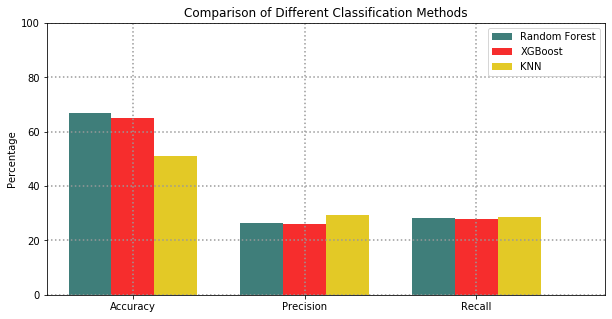

In [145]:
# Setting the positions and width for the bars
pos = list(range(len(df['Random Forest']))) 
width = 0.25 

#plt.figure(figsize=(14, 9))


# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['Random Forest'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#3f7e7a', 
        # with label the first value in first_name
        label=df['first_name'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['XGBoost'],
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#f62d2d', 
        # with label the second value in first_name
        label=df['first_name'][1]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df['KNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#e3c926', 
        # with label the third value in first_name
        label=df['first_name'][2]) 

# Set the y axis label
ax.set_ylabel('Percentage')

# Set the chart's title
ax.set_title('Comparison of Different Classification Methods')

# Set the position of the x ticks
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['first_name'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 100] )

# Adding the legend and showing the plot
plt.legend(['Random Forest', 'XGBoost', 'KNN'], loc='upper right')
plt.grid()
plt.grid(lw = 1.5, ls = 'dotted', c = "0.6", which = 'major')

#plt.savefig("./figs/" + plt.gca().get_title().replace("\n", "-") + ".png", bbox_inches="tight")

plt.show()